# Excess deaths due to COVID-19

In [1]:
import pandas as pd
from pymc_extras.prior import Prior

import causalpy as cp

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Load data

In [3]:
df = (
    cp.load_data("covid")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2020-01-01")
df.head()

,temp,deaths,year,month,t,pre
date,,,,,,
2006-01-01,3.8,49124,2006,1,0,True
2006-02-01,3.4,42664,2006,2,1,True
2006-03-01,3.9,49207,2006,3,2,True
2006-04-01,7.4,40645,2006,4,3,True
2006-05-01,10.7,42425,2006,5,4,True


The columns are:

* `date` + `year`: self explanatory
* `month`: month, numerically encoded. Needs to be treated as a categorical variable
* `temp`: average UK temperature (Celsius)
* `t`: time
* `pre`: boolean flag indicating pre or post intervention

## Run the analysis

In this example we are going to standardize the data. So we have to be careful in how we interpret the inferred regression coefficients, and the posterior predictions will be in this standardized space.

First, we'll build a linear regression model, but specify custom priors for the regression coefficients `beta` and the likelihood distribution `y_hat`. We stick with a relatively simple specification for the `mu` values of the coefficients, sticking with zero for all but the intercept. A value of 42,000 was chosen as this is the approximate median number of deaths per month in the UK.

In [4]:
model = cp.pymc_models.LinearRegression(
    sample_kwargs={"random_seed": seed},
    priors={
        "beta": Prior(
            "Normal",
            mu=[42_000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            sigma=10_000,
            dims=["treated_units", "coeffs"],
        ),
        "y_hat": Prior(
            "Normal",
            sigma=Prior("HalfNormal", sigma=10_000, dims=["treated_units"]),
            dims=["obs_ind", "treated_units"],
        ),
    },
)

Now we'll build the `InterruptedTimeSeries` experiment object, passing in our custom model. The formula specifies:
* an intercept term (`1`)
* a linear trend over time (`t`)
* a categorical variable for month (`month`)
* a temperature variable (`temp`)

In [5]:
result = cp.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="deaths ~ 1 + t + C(month) + temp",
    model=model,
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


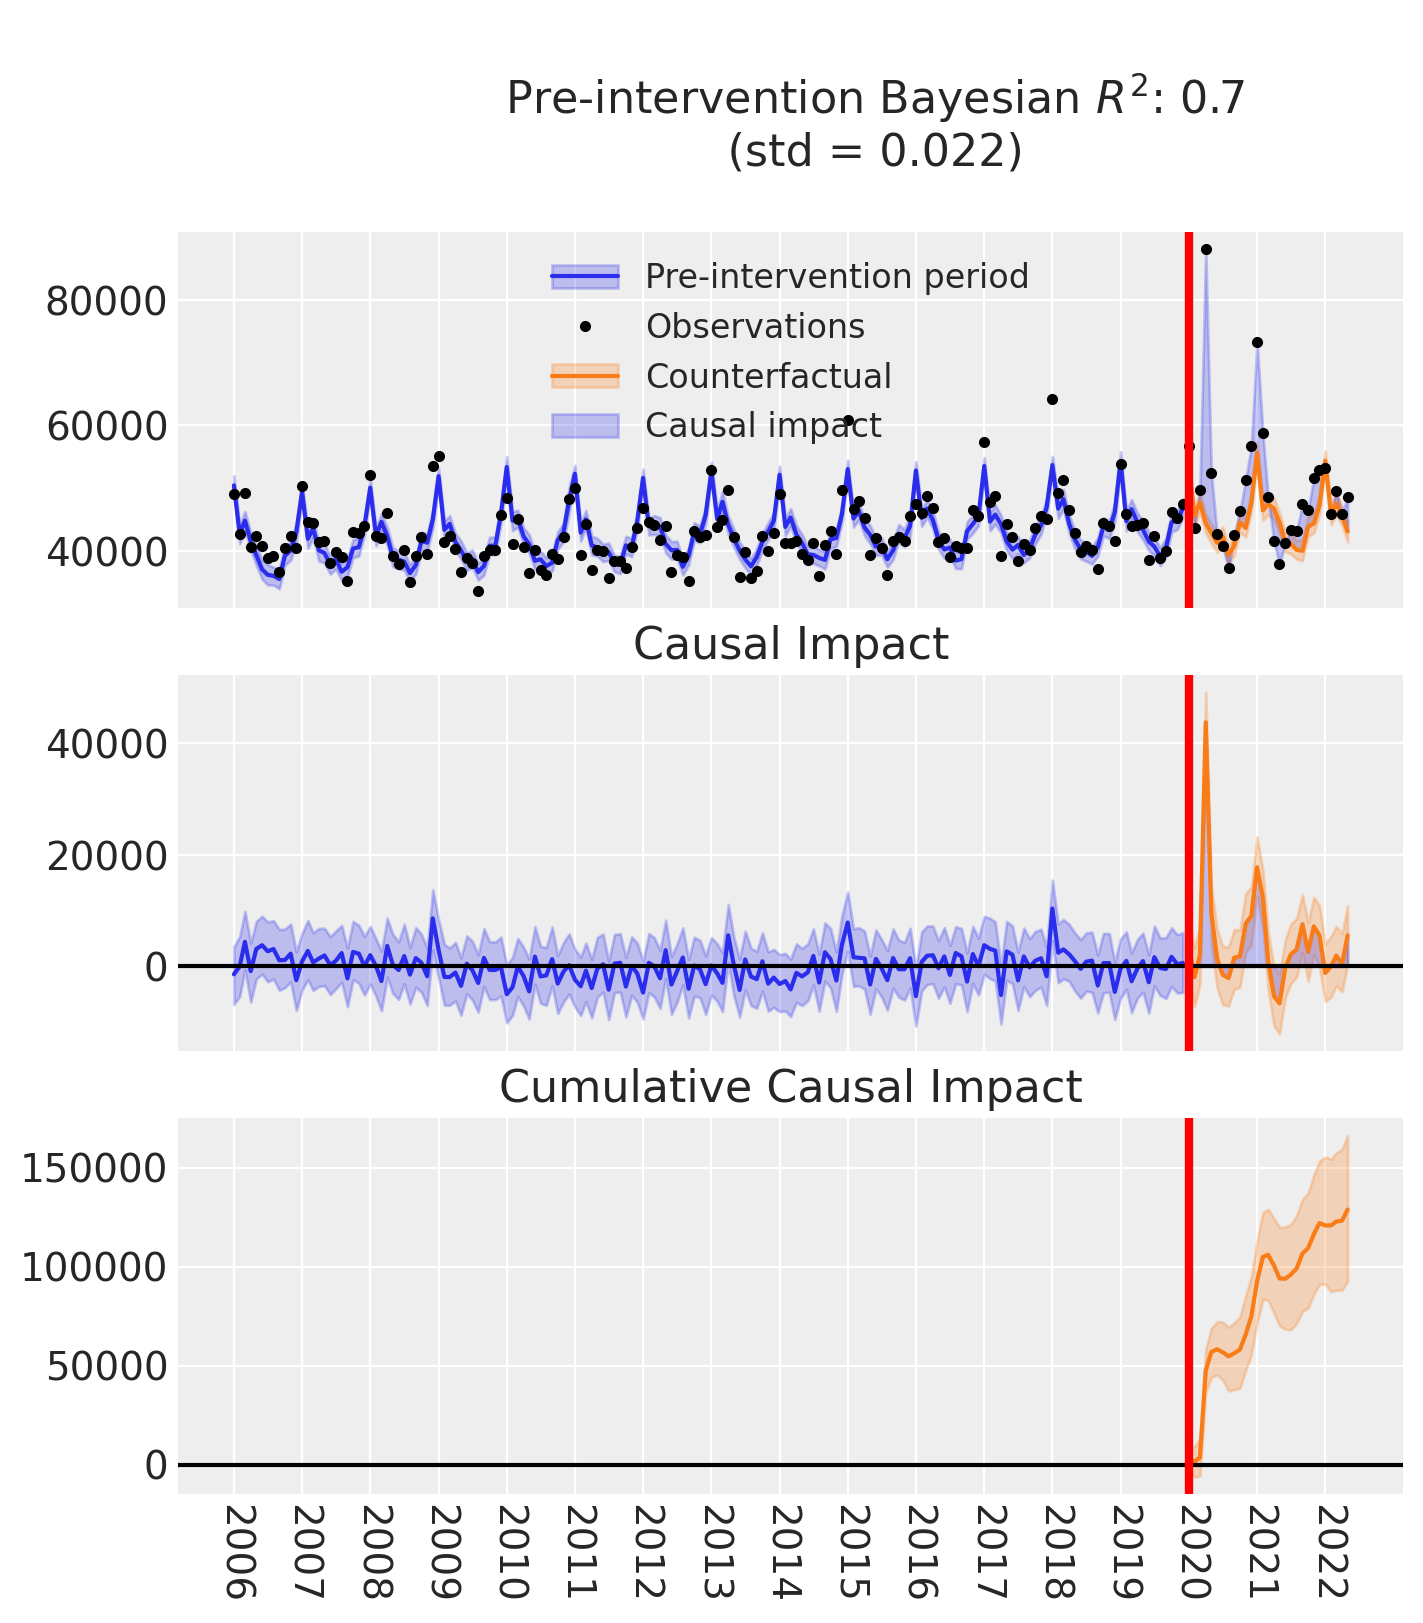

In [6]:
fig, ax = result.plot()

# figure customization
ax[2].set_xticks(pd.date_range(start=df.index.min(), end=df.index.max(), freq="YS"))
ax[2].set_xticklabels(
    pd.date_range(start=df.index.min(), end=df.index.max(), freq="YS").year
)
ax[2].tick_params(axis="x", rotation=-90)

In [7]:
result.summary()

==================================Pre-Post Fit==================================
Formula: deaths ~ 1 + t + C(month) + temp
Model coefficients:
    Intercept       52799, 94% HDI [50959, 54693]
    C(month)[T.2]   -8029, 94% HDI [-9934, -6187]
    C(month)[T.3]   -5622, 94% HDI [-7518, -3698]
    C(month)[T.4]   -6761, 94% HDI [-8901, -4585]
    C(month)[T.5]   -6953, 94% HDI [-9777, -4217]
    C(month)[T.6]   -6890, 94% HDI [-10198, -3573]
    C(month)[T.7]   -5737, 94% HDI [-9579, -1946]
    C(month)[T.8]   -7716, 94% HDI [-11411, -4157]
    C(month)[T.9]   -8068, 94% HDI [-11350, -4873]
    C(month)[T.10]  -6600, 94% HDI [-9115, -4114]
    C(month)[T.11]  -8520, 94% HDI [-10485, -6526]
    C(month)[T.12]  -6696, 94% HDI [-8618, -4820]
    t               23, 94% HDI [16, 31]
    temp            -621, 94% HDI [-921, -331]
    y_hat_sigma     2684, 94% HDI [2421, 3001]
